In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:
import pickle

# Load data from file
with open('data_all_outer.pkl', 'rb') as f:
    data = pickle.load(f)

Additional data from https://ourworldindata.org/grapher/co2-per-capita-vs-renewable-electricity?tab=table

In [13]:
# get the absolute path of the current working directory
cwd = os.path.abspath(os.getcwd())

# go up one level in the directory tree
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))

# go into the 'data' directory
data_dir = os.path.join(parent_dir, 'data')
datafolder = data_dir + '\\' #'./data/' 
co2 = pd.read_csv(datafolder + 'annual-co-emissions-by-region.csv')
renewable_energy = pd.read_csv(datafolder + 'co2-per-capita-vs-renewable-electricity.csv')

In [14]:
data = data.merge(renewable_energy[['Entity', 'Renewables (% electricity)', 'Year']], 
                              left_on = ['country', 'dt_year'], right_on = ['Entity', 'Year'], how = 'left')

In [15]:
# Only keep countries that have info about CO2
data_viz = data[data.country.isin(co2.Entity)]

In [16]:
# Extract interesting feature based on Milestone 1
data_viz = data_viz[['dt_year', 'country','co2emissions_from_fuel_combustion_in_millions_of_tonnes', 
      'total_government_revenue_proportion_of_gdp_perc',  'fdi_inflows_millionusd',
      'annual_growth_rate_perc',
      'Annual CO₂ emissions (zero filled)',
     'GDP (constant 2015 US$)', 'mortality_rate_perc',
         'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
         'Literacy rate, adult total (% of people ages 15 and above)', 'Renewables (% electricity)']]

In [17]:
# Interpolate between measurement
data_viz = data_viz.groupby('country').apply(pd.DataFrame.interpolate)

In [18]:
# Rename feature
rename_dict = {'dt_year': 'Year', 'co2emissions_from_fuel_combustion_in_millions_of_tonnes': 'CO2_fuel_combustion', 
      'total_government_revenue_proportion_of_gdp_perc':'Revenue',  'fdi_inflows_millionusd':'FDI',
      'annual_growth_rate_perc':'Growth_rate',
      'Annual CO₂ emissions (zero filled)':'CO2_emission',
     'GDP (constant 2015 US$)':'GDP', 'mortality_rate_perc':'Mortality_rate',
         'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)':'Air pollution',
         'Literacy rate, adult total (% of people ages 15 and above)':'Literacy rate', 
              'Renewables (% electricity)': 'Renewable_energy'}

In [19]:
data_viz = data_viz.rename(columns=rename_dict)

In [243]:
data_viz.to_pickle("./data_viz.pkl")

In [20]:
# Calculate number of NaN
def NaN_percentage(df):
    '''
    Returns a df with columnname and their respective number of NaN and what percentage this corresponds to.
    Args:
        df = movies, characters
    '''
    
    n_NaN = []
    perc_NaN = []
    length = len(df)

    for column in df:
        i_nan = df[column].isna().sum()
        perc_nan = i_nan/ length
        n_NaN.append(i_nan)
        perc_NaN.append(perc_nan)

    # Create df with results
    index_df = df.columns.to_list()
    df_NaN = pd.DataFrame({'number of NaN':n_NaN, 'percentage of NaN':perc_NaN}, index= index_df )
    return df_NaN

***
#### Correlation matrix - heatmap
Availability of data varies with time -> divide data into 2002 - 2005, 2005-2010, 2010-2015, 2015-2021. <br>
Keep features that have a NaN perc <= 30% <br>
remove all records that contain NaN

In [21]:
import plotly as plotly
import plotly.io as pio
import plotly.graph_objects as go

In [22]:
corr_viz1 = data_viz[(data_viz.Year<2005)]
corr_viz2 = data_viz[(data_viz.Year>=2005)&(data_viz.Year<2010)]
corr_viz3 = data_viz[(data_viz.Year>=2010)&(data_viz.Year<2015)]
corr_viz4 = data_viz[(data_viz.Year>=2015)]

In [23]:
NaN_percentage(corr_viz1)

,number of NaN,percentage of NaN
Year,0,0.000000
country,0,0.000000
CO2_fuel_combustion,231,0.385000
Revenue,261,0.435000
FDI,63,0.105000
Growth_rate,51,0.085000
CO2_emission,0,0.000000
GDP,80,0.133333
Mortality_rate,600,1.000000
Air pollution,600,1.000000


In [24]:
import plotly.offline as offline

In [50]:
period = 3
if period ==1:
        df_viz = corr_viz1
elif period == 2:
        df_viz = corr_viz2
elif period == 3:
        df_viz = corr_viz3  
elif period == 4:
        df_viz = corr_viz4
else:
        print('Error, no valid Period')

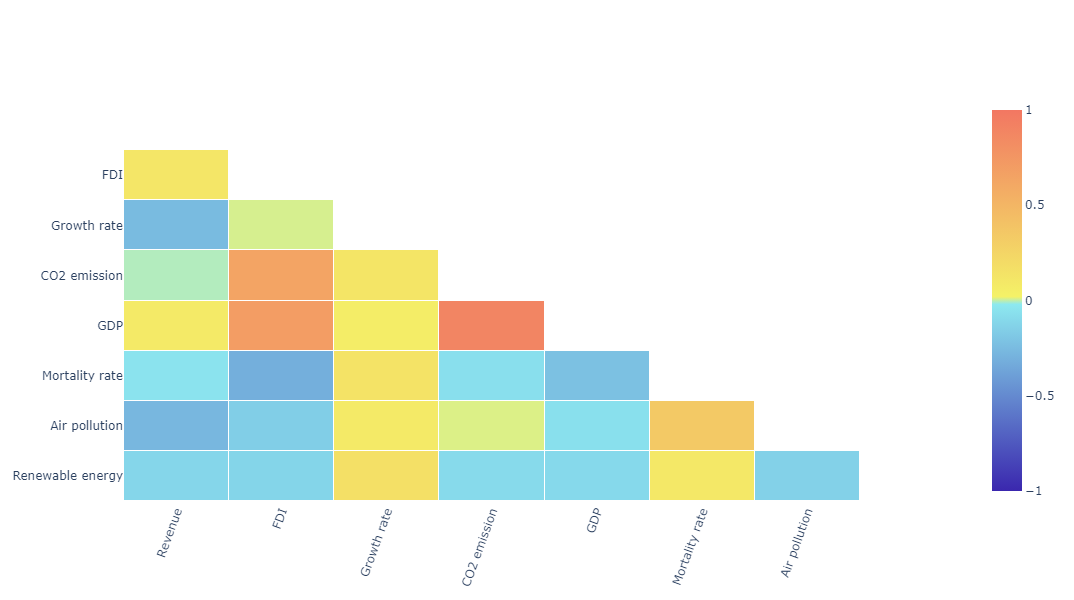

In [51]:
def corr_heatmap(corr, period):
    custom_colorscale = [
    [0, '#3A27AE'],
    [0.49, '#8DE9F0'], 
    [0.51, '#F4F267'],
    [1, '#F27762']]
    
    nan_perc = NaN_percentage(corr)
    keep_index = nan_perc[nan_perc.iloc[:,1]<=0.3].index[2:]
    corr = corr.loc[:,keep_index].dropna()
    corr_matrix  = corr.corr() # Compute pairwise correlation of columns, excluding NA/null values.
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matr_viz = corr_matrix.mask(mask)
    pio.templates.default = "plotly_white"

    heat = go.Heatmap(
        z = corr_matr_viz,
        x = corr_matr_viz.columns.values,
        y = corr_matr_viz.columns.values,
        zmin = - 1, # Sets the lower bound of the color domain
        zmax = 1,
        xgap = 1, # Sets the horizontal gap (in pixels) between bricks
        ygap = 1,
        colorscale = custom_colorscale #'thermal'
    )
    if period ==1:
        x_dict = dict(
                ticktext= ['FDI', 'Growth rate', 'CO2 emission', 'GDP', ''],
                tickvals=list(range(len(corr_matr_viz.columns))))

        y_dict = dict(
                ticktext= ['', 'Growth rate', 'CO2 emission', 'GDP',
           'Renewable energy share'],
                tickvals=list(range(len(corr_matr_viz.columns))))
    elif period == 2:
        x_dict = dict(
                ticktext= ['FDI', 'Growth rate', 'CO2 emission', 'GDP', 'Mortality rate','Air pollution',''],
                tickvals=list(range(len(corr_matr_viz.columns))))

        y_dict = dict(
                ticktext= ['', 'Growth rate', 'CO2 emission', 'GDP','Mortality rate','Air pollution','Renewable energy'],
                tickvals=list(range(len(corr_matr_viz.columns))))
    elif period == 3:
        x_dict = dict(
                ticktext= ['Revenue','FDI', 'Growth rate', 'CO2 emission', 'GDP', 'Mortality rate','Air pollution',''],
                tickvals=list(range(len(corr_matr_viz.columns))))

        y_dict = dict(
                ticktext= ['', 'FDI', 'Growth rate', 'CO2 emission', 'GDP','Mortality rate','Air pollution','Renewable energy'],
                tickvals=list(range(len(corr_matr_viz.columns))))      
    elif period == 4:
        x_dict = dict(
                ticktext= ['Revenue','FDI', 'Growth rate', 'CO2 emission', 'GDP', 'Mortality rate','Air pollution',''],
                tickvals=list(range(len(corr_matr_viz.columns))))

        y_dict = dict(
                ticktext= ['', 'FDI', 'Growth rate', 'CO2 emission', 'GDP','Mortality rate','Air pollution','Renewable energy'],
                tickvals=list(range(len(corr_matr_viz.columns))))         
    else:
        print('Error, no valid Period')

    layout = go.Layout(
        width=600, 
        height=600,
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        yaxis_autorange='reversed',
        xaxis_tickangle= -70,
        xaxis= x_dict, 
        yaxis = y_dict)

    fig=go.Figure(data=[heat], layout=layout)
    config = {'displayModeBar': False}

    # display the figure with the config object
    fig.show(config=config)
    
    #fig.write_html(datafolder+"heatmap2.html", config=config)
    #plotly.offline.plot(fig, filename='file.html')
    offline.plot(fig,  include_plotlyjs=False, output_type='div')
    return corr_matr_viz, x_dict, y_dict
    
corr_matr_viz, x_dict, y_dict = corr_heatmap(df_viz, period) # To change depending on plot

In [45]:
corr_matr_viz.columns = x_dict['ticktext']
corr_matr_viz.index = y_dict['ticktext']

In [46]:
corr_matr_viz

,Revenue,FDI,Growth rate,CO2 emission,GDP,Mortality rate,Air pollution,
,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FDI,0.053130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Growth rate,0.002213,0.077261,NaN,NaN,NaN,NaN,NaN,NaN
CO2 emission,-0.016778,0.578636,0.084888,NaN,NaN,NaN,NaN,NaN
GDP,0.063355,0.631372,0.073640,0.937594,NaN,NaN,NaN,NaN
Mortality rate,-0.030364,-0.268463,0.015455,-0.069783,-0.188639,NaN,NaN,NaN
Air pollution,-0.257195,-0.170872,-0.025501,0.018557,-0.066254,0.415267,NaN,NaN
Renewable energy,-0.061372,-0.080014,0.046828,-0.076631,-0.065863,-0.015529,-0.198945,NaN


In [47]:
viz_df = corr_matr_viz.reset_index().melt(id_vars=['index'], var_name='x_axis', value_name='value')

# swap columns
viz_df.iloc[:, [1, 0]] = viz_df.iloc[:, [0, 1]].values
viz_df = viz_df.rename(columns={"index":"y_axis"})

In [48]:
viz_df

,y_axis,x_axis,value
0,Revenue,,NaN
1,Revenue,FDI,0.053130
2,Revenue,Growth rate,0.002213
3,Revenue,CO2 emission,-0.016778
4,Revenue,GDP,0.063355
...,...,...,...
59,,CO2 emission,NaN
60,,GDP,NaN
61,,Mortality rate,NaN
62,,Air pollution,NaN


In [49]:
viz_df.to_csv('viz_df.csv', index=False)